In [1]:
# %%
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import boxcox

In [2]:
# %%
# Load the dataset
file_path = "../data/nberces5818v1_n2012.csv"
df = pd.read_csv(file_path)

# Display basic info about the dataset
df.info()

# %%
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

# %%
# Summary statistics
summary_stats = df.describe()

print(summary_stats)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22204 entries, 0 to 22203
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   naics    22204 non-null  int64  
 1   year     22204 non-null  int64  
 2   emp      22087 non-null  float64
 3   pay      22087 non-null  float64
 4   prode    22087 non-null  float64
 5   prodh    22087 non-null  float64
 6   prodw    22087 non-null  float64
 7   vship    22087 non-null  float64
 8   matcost  22087 non-null  float64
 9   vadd     22087 non-null  float64
 10  invest   21723 non-null  float64
 11  invent   22087 non-null  float64
 12  energy   22087 non-null  float64
 13  cap      21359 non-null  float64
 14  equip    21359 non-null  float64
 15  plant    21359 non-null  float64
 16  piship   22087 non-null  float64
 17  pimat    22087 non-null  float64
 18  piinv    21359 non-null  float64
 19  pien     22087 non-null  float64
 20  dtfp5    20995 non-null  float64
 21  tfp5     213

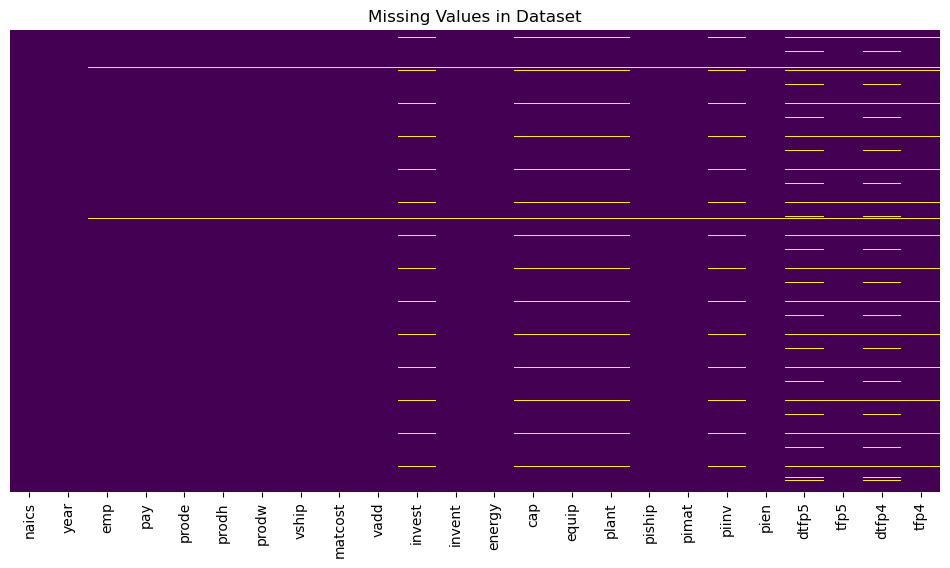

In [3]:
# %%
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()

In [4]:
# %%
# Step 1: Convert NAICS Codes to String and Filter for Manufacturing (31-33)
df["naics"] = df["naics"].astype(str)
df = df[df["naics"].str.startswith(("31", "32", "33"))].copy()

# Step 2: Define Core Manufacturing Subcategories (Excluding 323 & 324)
core_manufacturing_subcategories = {
    "311": "Food Manufacturing",
    "312": "Beverage & Tobacco Product Manufacturing",
    "313": "Textile Mills",
    "314": "Textile Product Mills",
    "315": "Apparel Manufacturing",
    "316": "Leather & Allied Product Manufacturing",
    "321": "Wood Product Manufacturing",
    "322": "Paper Manufacturing",
    "325": "Chemical Manufacturing",
    "326": "Plastics & Rubber Products Manufacturing",
    "327": "Nonmetallic Mineral Product Manufacturing",
    "331": "Primary Metal Manufacturing",
    "332": "Fabricated Metal Product Manufacturing",
    "333": "Machinery Manufacturing",
    "334": "Computer & Electronic Product Manufacturing",
    "335": "Electrical Equipment, Appliance & Component Manufacturing",
    "336": "Transportation Equipment Manufacturing",
    "337": "Furniture & Related Product Manufacturing",
    "339": "Miscellaneous Manufacturing"
}

# Step 3: Assign Subcategories Based on NAICS Prefix
df["Subcategory"] = df["naics"].str[:3].map(core_manufacturing_subcategories)

# Step 4: Remove Non-Core Manufacturing Categories (Rows where Subcategory is NaN)
df = df.dropna(subset=["Subcategory"])

# Reset index for clean output
df.reset_index(drop=True, inplace=True)


In [5]:
# Define feature and target variables
features = ['emp', 'pay', 'prode', 'invest', 'cap', 'matcost', 'vadd']
targets = ['dtfp5', 'dtfp4']

# Unique NAICS Groups
unique_naics = df['naics'].unique()

# Iterate Over Each NAICS Group
for naics_code in unique_naics:
    subset_df = df[df['naics'] == naics_code].copy()

    # 1️⃣ Handle Moderate Missingness with Rolling Median
    moderate_missing_cols = ['invest', 'cap', 'equip', 'plant', 'piinv', 'tfp5', 'tfp4']
    subset_df[moderate_missing_cols] = subset_df[moderate_missing_cols].rolling(5, min_periods=1).median()
    subset_df[moderate_missing_cols] = subset_df[moderate_missing_cols].fillna(subset_df[moderate_missing_cols].median())

    # 2️⃣ Apply Industry-Specific Interpolation for Continuous Trends
    continuous_cols = ['emp', 'pay', 'prode', 'prodh', 'prodw', 'vship', 'matcost', 'vadd', 'energy', 'invent']
    subset_df[continuous_cols] = subset_df[continuous_cols].interpolate(method='spline', order=3)

    # 3️⃣ Apply Macroeconomic Adjustments with Spline Interpolation
    macro_cols = ['piship', 'pimat', 'piinv', 'pien']
    subset_df[macro_cols] = subset_df[macro_cols].interpolate(method='spline', order=3)

    # 4️⃣ Predict Missing Values using RandomForest
    train_data = subset_df.dropna(subset=targets + features)
    if not train_data.empty:
        for target in targets:
            if subset_df[target].isna().sum() > 0:
                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                rf.fit(train_data[features], train_data[target])

                # Predict only for missing values
                missing_rows = subset_df[subset_df[target].isna() & subset_df[features].notnull().all(axis=1)]
                if not missing_rows.empty:
                    df.loc[missing_rows.index, target] = rf.predict(missing_rows[features])

    # 5️⃣ Apply KNN Imputation for Remaining Missing Values
    knn_imputer = KNNImputer(n_neighbors=5)
    df.loc[df['naics'] == naics_code, targets] = knn_imputer.fit_transform(subset_df[targets])

# Verify missing values
print("Final Missing Values:\n", df.isnull().sum())


/opt/conda/envs/portfolio/lib/python3.11/site-packages/pandas/core/missing.py:522: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


Final Missing Values:
 naics            0
year             0
emp            117
pay            117
prode          117
prodh          117
prodw          117
vship          117
matcost        117
vadd           117
invest         472
invent         117
energy         117
cap            827
equip          827
plant          827
piship         117
pimat          117
piinv          827
pien           117
dtfp5            0
tfp5           827
dtfp4            0
tfp4           827
Subcategory      0
dtype: int64


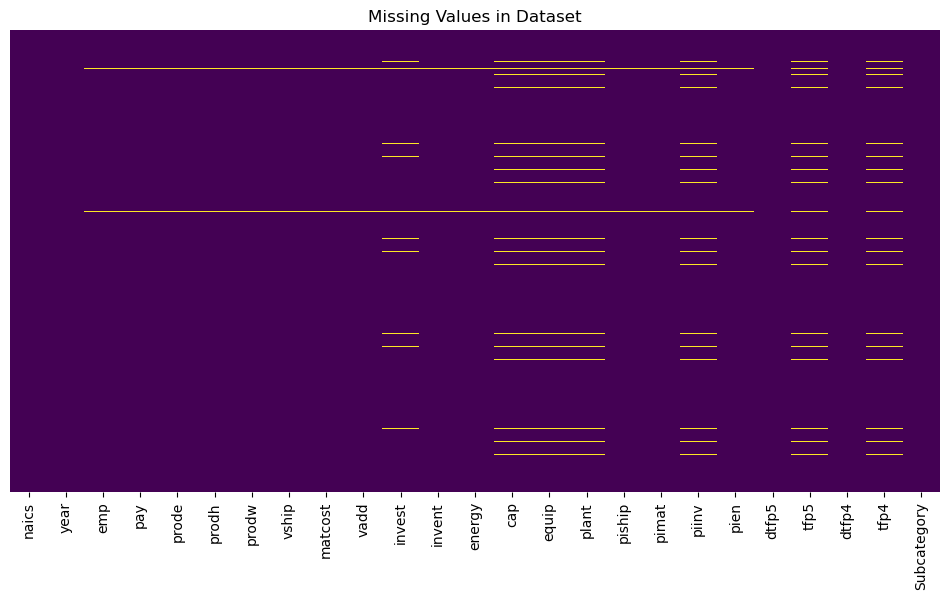

In [6]:
# %%
# df.drop(columns=['naics'], inplace=True)

# %%
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()


/tmp/ipykernel_184166/3500437902.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)


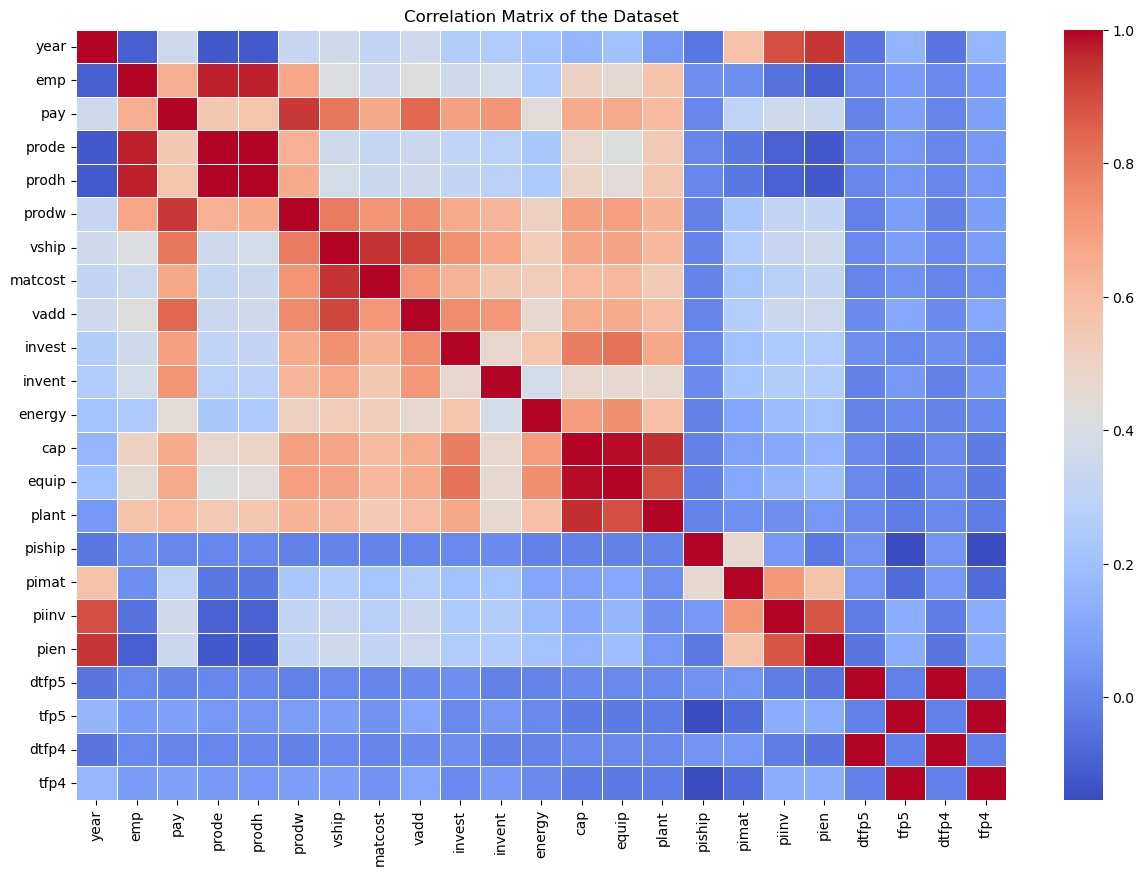

In [7]:
# %%
# Correlation Matrix
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of the Dataset")
plt.show()

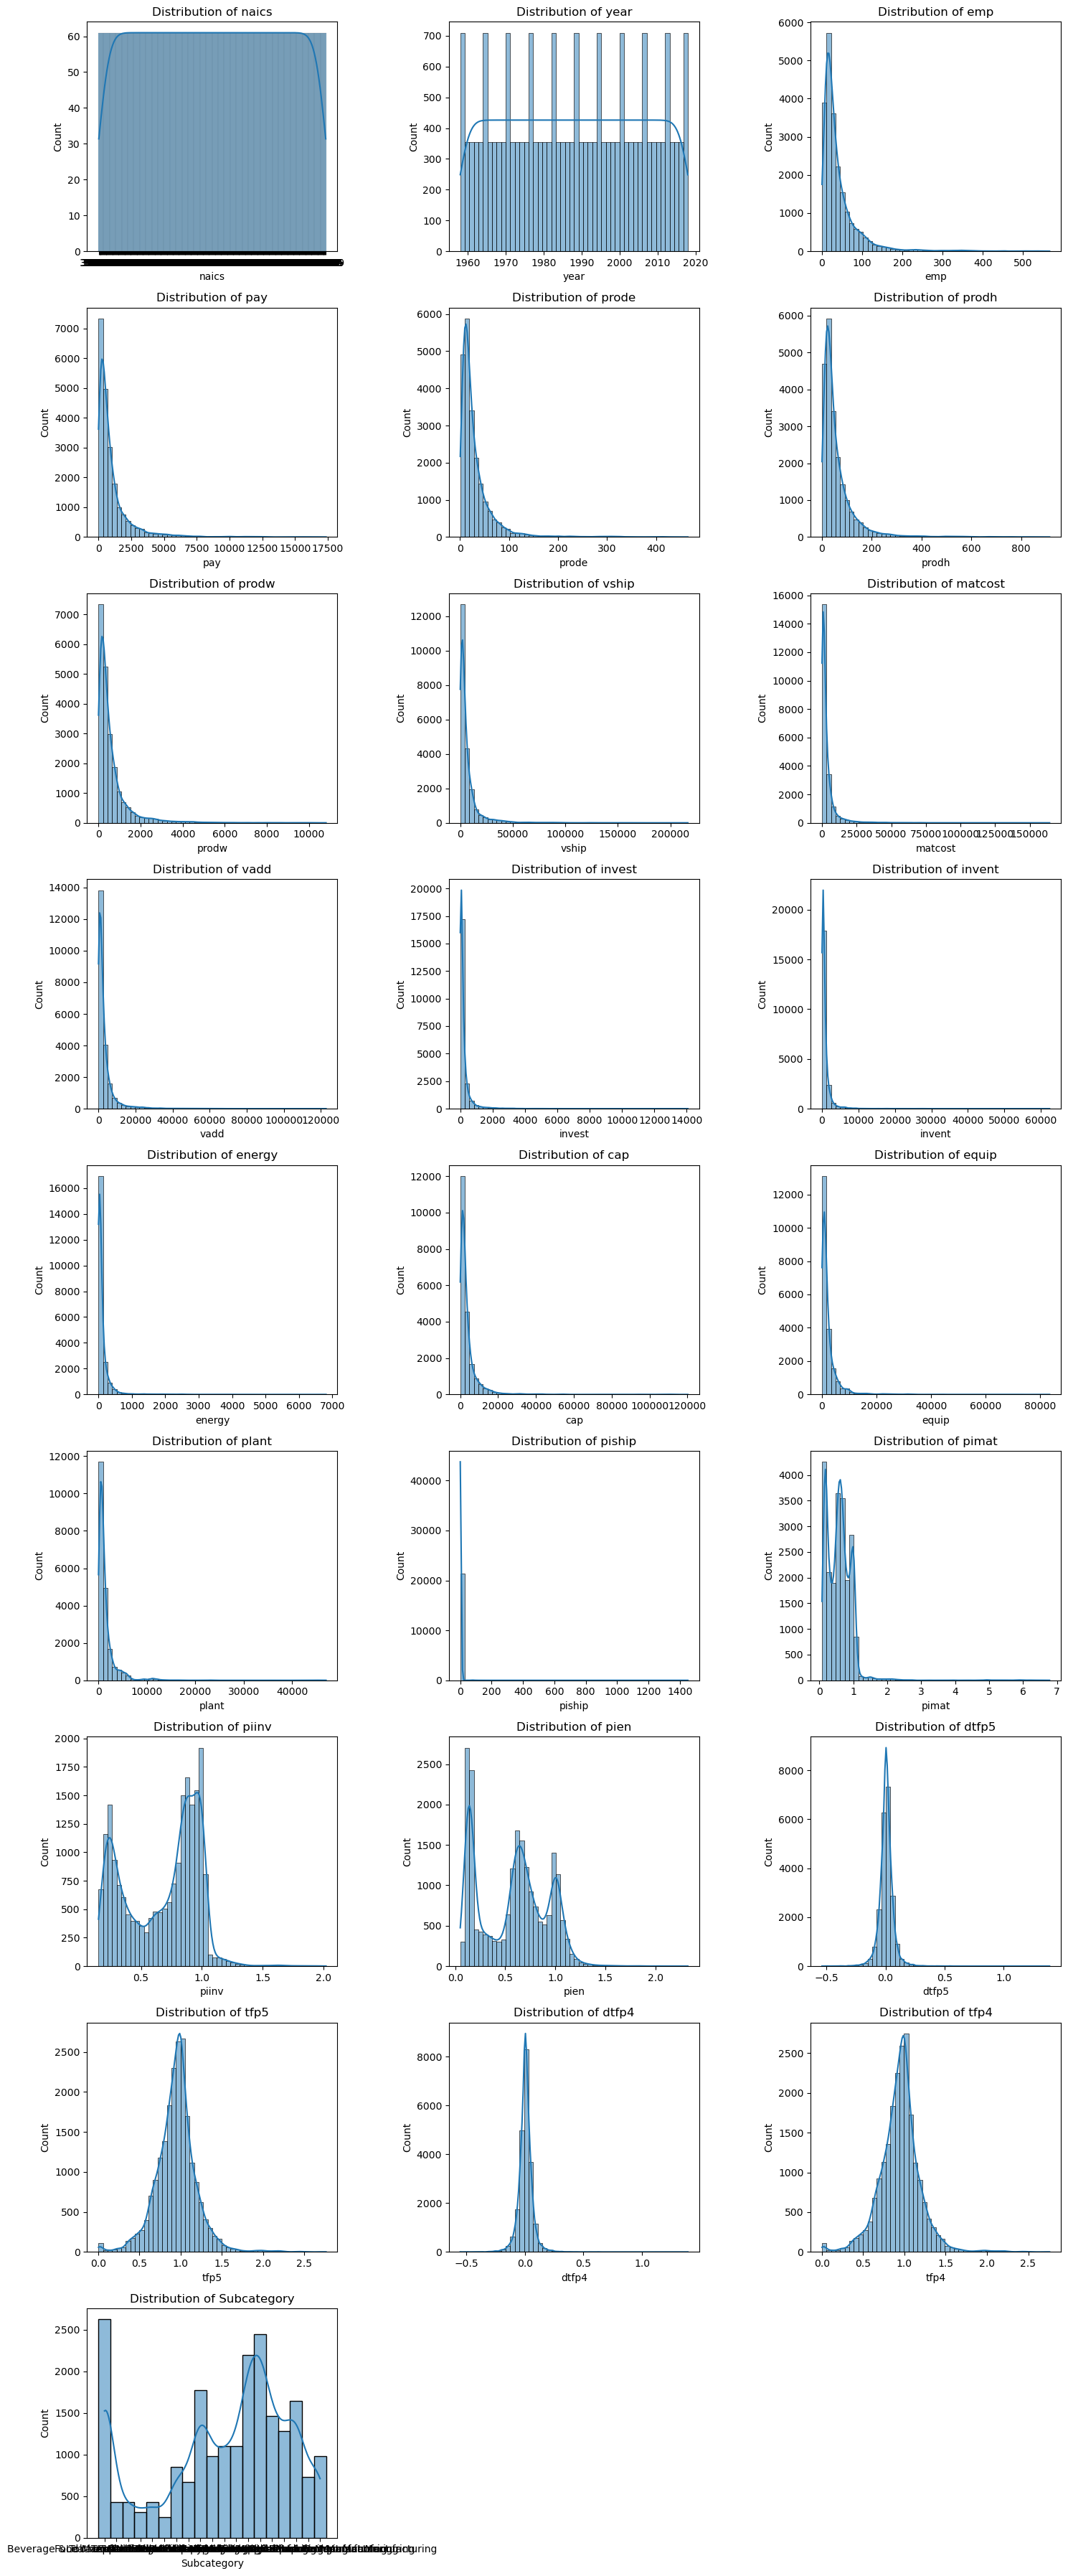

In [8]:
# %%
def plot_feature_distributions(df, max_cols=3):
    """
    Plots histograms for all columns in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing features to plot.
        max_cols (int): Maximum number of columns per row in the subplot grid.
    """
    num_features = len(df.columns)
    num_rows = math.ceil(num_features / max_cols)  # Calculate required rows

    plt.figure(figsize=(max_cols * 5, num_rows * 4))  # Adjust figure size dynamically

    for i, feature in enumerate(df.columns, 1):
        plt.subplot(num_rows, max_cols, i)
        sns.histplot(df[feature].dropna(), bins=50, kde=True)
        plt.title(f"Distribution of {feature}")

    plt.tight_layout()
    plt.show()
plot_feature_distributions(df, max_cols=3)


In [9]:
df.skew()


/tmp/ipykernel_184166/547062910.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


naics      -0.710232
year        0.000000
emp         3.942947
pay         4.168302
prode       4.553575
prodh       4.344258
prodw       4.228540
vship       5.745145
matcost     6.999030
vadd        7.307541
invest     10.615164
invent     13.811848
energy      8.382662
cap         7.935725
equip       7.989772
plant       8.335136
piship     31.900981
pimat       5.196477
piinv      -0.264508
pien        0.049875
dtfp5       1.090556
tfp5        0.306613
dtfp4       1.077093
tfp4        0.294502
dtype: float64

In [10]:
def preprocess_nans(df, strategy='median'):
    """
    Handles NaN values before transformations.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - strategy (str): Method to handle NaNs ('mean', 'median', 'zero').

    Returns:
    - df_filled (pd.DataFrame): Dataframe with NaNs handled.
    - nan_replacements (dict): Dictionary storing replacements for restoration.
    """
    df_filled = df.copy()
    nan_replacements = {}  # Store original NaN locations

    for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numeric columns
        if df[col].isna().sum() > 0:
            if strategy == 'median':
                fill_value = df[col].median()
            elif strategy == 'mean':
                fill_value = df[col].mean()
            else:  # Zero filling
                fill_value = 0

            fill_value = fill_value if not np.isnan(fill_value) else 0  # Handle edge case
            df_filled[col].fillna(fill_value, inplace=True)
            nan_replacements[col] = fill_value  # Store for later restoration

    return df_filled, nan_replacements


def transform_skewed_features(df, exclude_columns=None):
    """
    Transforms skewed features while excluding specified columns.
    Handles NaNs before transformation.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - exclude_columns (list, optional): Columns to exclude from transformations.

    Returns:
    - df_transformed (pd.DataFrame): Transformed dataframe.
    - transformations (dict): Dictionary of applied transformations.
    - nan_replacements (dict): Dictionary storing NaN replacements.
    """
    if exclude_columns is None:
        exclude_columns = []

    df_cleaned, nan_replacements = preprocess_nans(df)  # Handle NaNs first
    df_transformed = df_cleaned.copy()
    transformations = {}  # Store transformations

    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    skewness = df_cleaned[numeric_cols].skew()

    columns_to_transform = [col for col in numeric_cols if col not in exclude_columns]

    for col in columns_to_transform:
        min_val = df_cleaned[col].min()

        if skewness[col] > 3 or skewness[col] < -3:  # EXTREME skewness
            shift = abs(min_val) + 1 if min_val <= 0 else 0  # Ensure positivity
            df_transformed[col] = np.log1p(df_transformed[col] + shift)
            transformations[col] = ('log1p_shift', shift)
        
        elif 1.5 < abs(skewness[col]) <= 3:  # MODERATE skewness
            df_transformed[col] = np.cbrt(df_transformed[col])
            transformations[col] = ('cbrt', None)

        elif 0.5 < abs(skewness[col]) <= 1.5:  # MILD skewness
            shift = abs(min_val) if min_val < 0 else 0
            df_transformed[col] = np.sqrt(df_transformed[col] + shift)
            transformations[col] = ('sqrt_shift', shift)

    return df_transformed, transformations, nan_replacements


def restore_original_values(df_transformed, transformations, nan_replacements):
    """
    Restores transformed values to their original scale and reintroduces NaNs.

    Parameters:
    - df_transformed (pd.DataFrame): Transformed dataframe.
    - transformations (dict): Mapping of column names to transformations.
    - nan_replacements (dict): Original NaN replacements.

    Returns:
    - df_original (pd.DataFrame): Restored dataframe.
    """
    df_original = df_transformed.copy()
    
    for col, transform in transformations.items():
        if transform[0] == 'log1p_shift':
            df_original[col] = np.expm1(df_original[col]) - transform[1]  # Undo shift
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error
        
        elif transform[0] == 'cbrt':
            df_original[col] = np.power(df_original[col], 3)  # Inverse of cube root
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error
        
        elif transform[0] == 'sqrt_shift':
            df_original[col] = (df_original[col] ** 2) - transform[1]  # Undo shift
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error

    # Restore NaNs safely using a mask instead of direct replacement
    for col, fill_value in nan_replacements.items():
        df_original[col] = df_original[col].mask(np.isclose(df_original[col], fill_value, atol=1e-6), np.nan)  

    return df_original

In [11]:
# %%
# Step 1: Transform Data (including handling NaNs)
df_transformed, transformations, nan_replacements = transform_skewed_features(df)

print(nan_replacements)
# Step 2: Restore to Original Values
df_original = restore_original_values(df_transformed, transformations, nan_replacements)


{'emp': 26.1, 'pay': 569.7, 'prode': 18.8, 'prodh': 37.6, 'prodw': 345.5, 'vship': 3342.2, 'matcost': 1630.6999999999998, 'vadd': 1609.9, 'invest': 87.3, 'invent': 439.7, 'energy': 44.4, 'cap': 1980.8, 'equip': 1127.15, 'plant': 814.3, 'piship': 0.621999979019165, 'pimat': 0.577000021934509, 'piinv': 0.778999984264374, 'pien': 0.620999991893768, 'tfp5': 0.954999983310699, 'tfp4': 0.954999983310699}


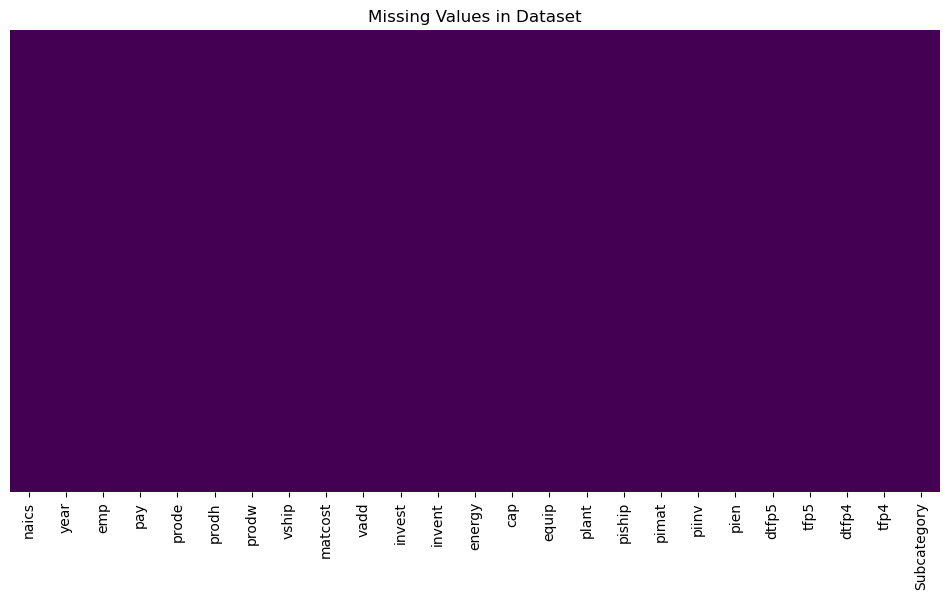

In [12]:
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df_transformed.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()

In [13]:
# Ensure only numeric columns are compared
numeric_df = df.select_dtypes(include=[np.number]).fillna(0)
numeric_df_original = df_original.select_dtypes(include=[np.number]).fillna(0)

# Compare only numeric values
print(np.allclose(numeric_df, numeric_df_original, atol=1e-6))  # Should return True

False


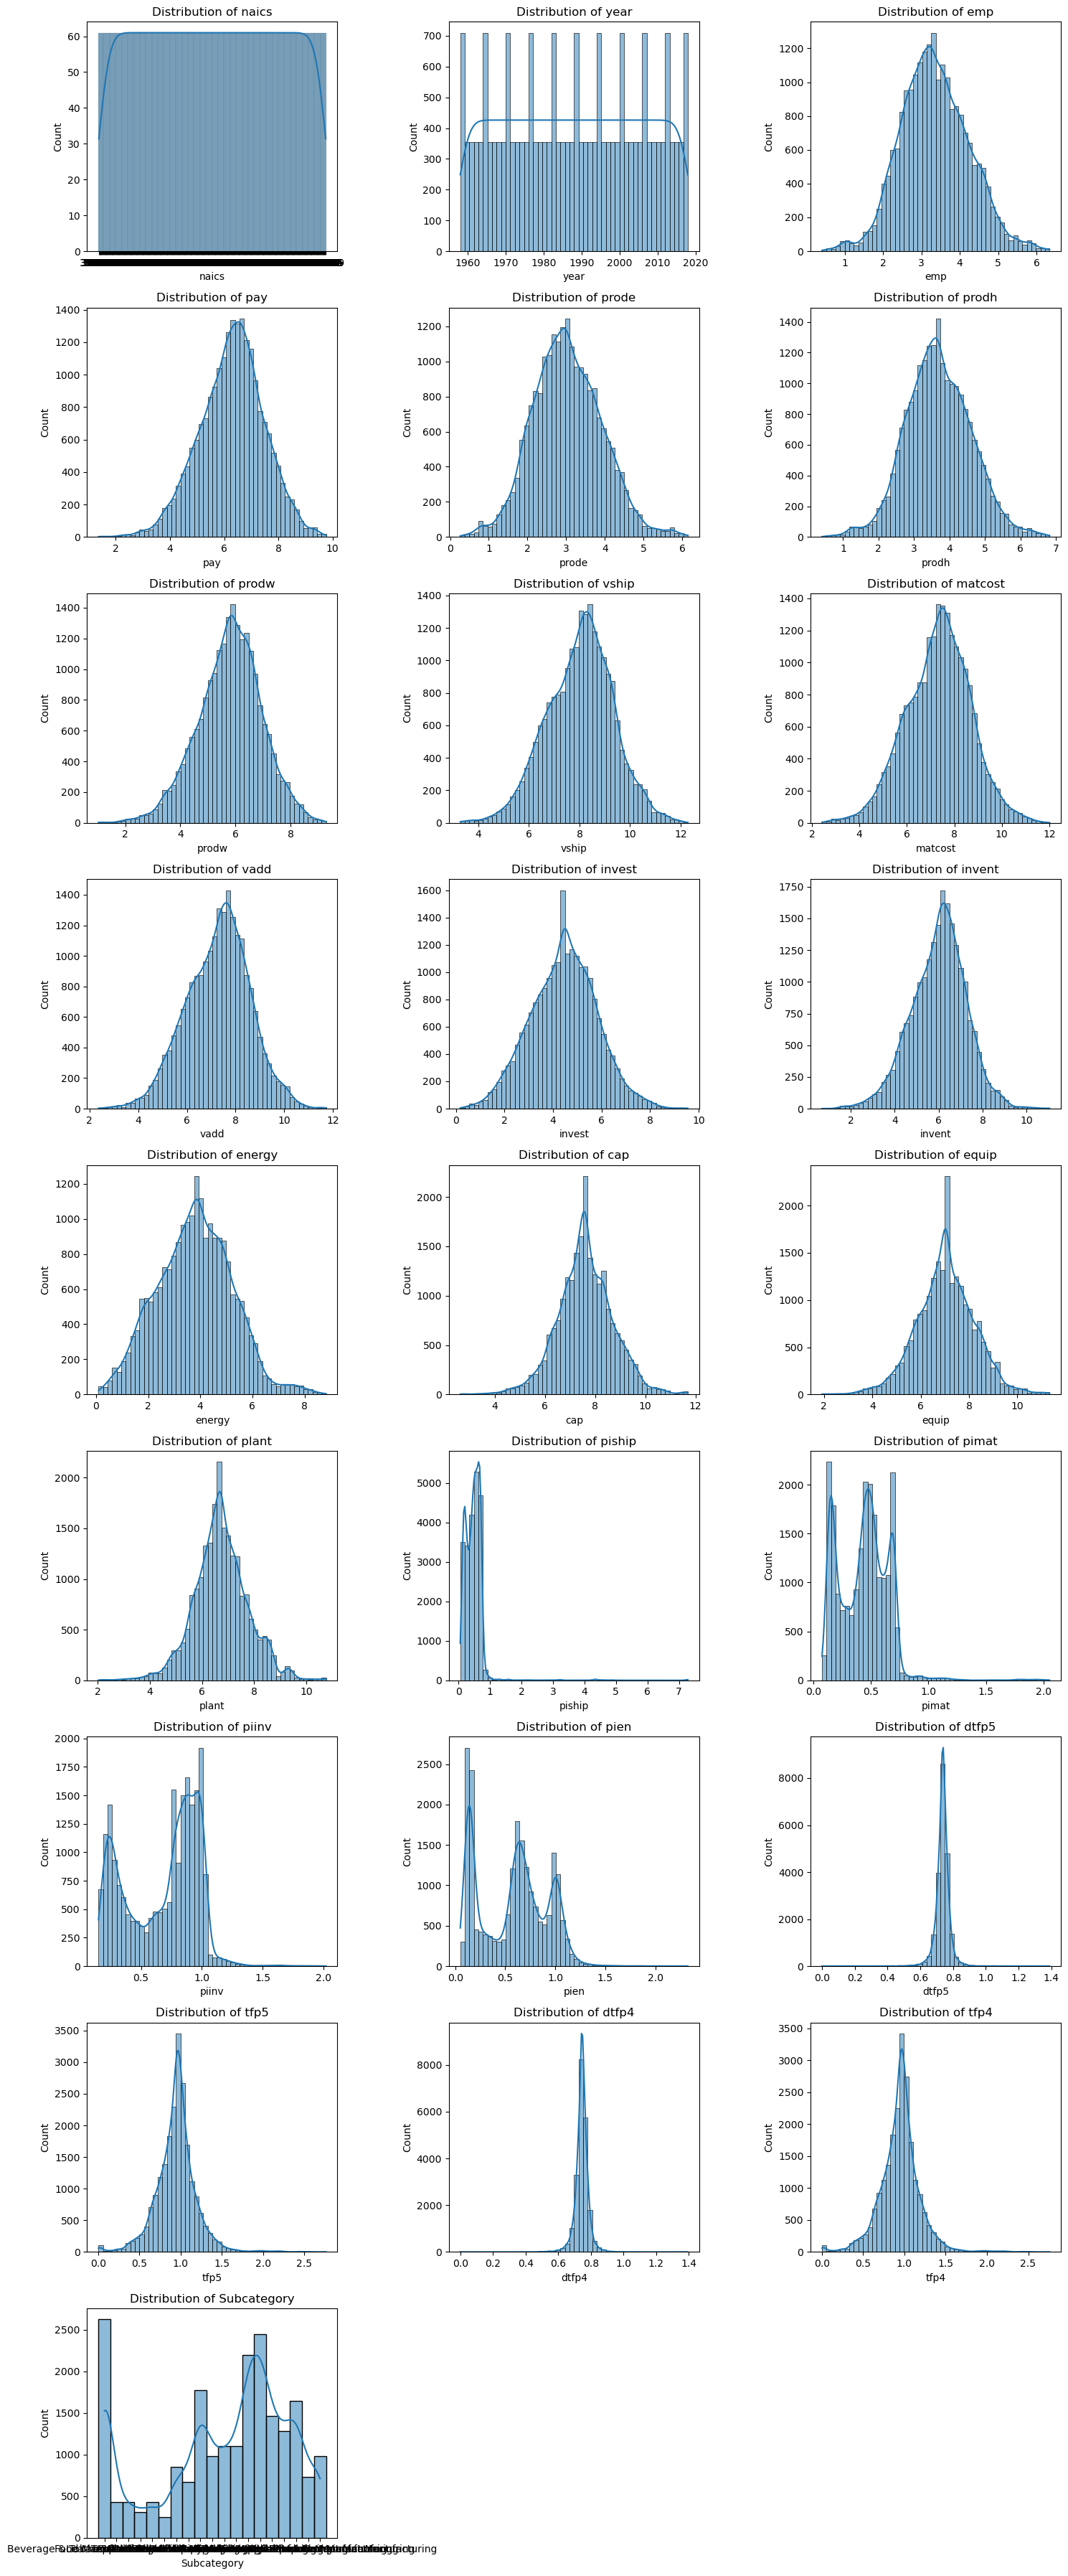

In [14]:
# %%
plot_feature_distributions(df_transformed, max_cols=3)


In [15]:
df_transformed.skew()

/tmp/ipykernel_184166/3832597954.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_transformed.skew()


naics     -0.710232
year       0.000000
emp        0.157840
pay       -0.215103
prode      0.202110
prodh      0.099253
prodw     -0.237644
vship     -0.171346
matcost   -0.143599
vadd      -0.183740
invest    -0.005003
invent    -0.220437
energy     0.114381
cap       -0.031484
equip     -0.061364
plant      0.023206
piship     8.894383
pimat      0.980059
piinv     -0.306855
pien       0.047879
dtfp5     -0.858337
tfp5       0.308137
dtfp4     -1.077634
tfp4       0.295380
dtype: float64

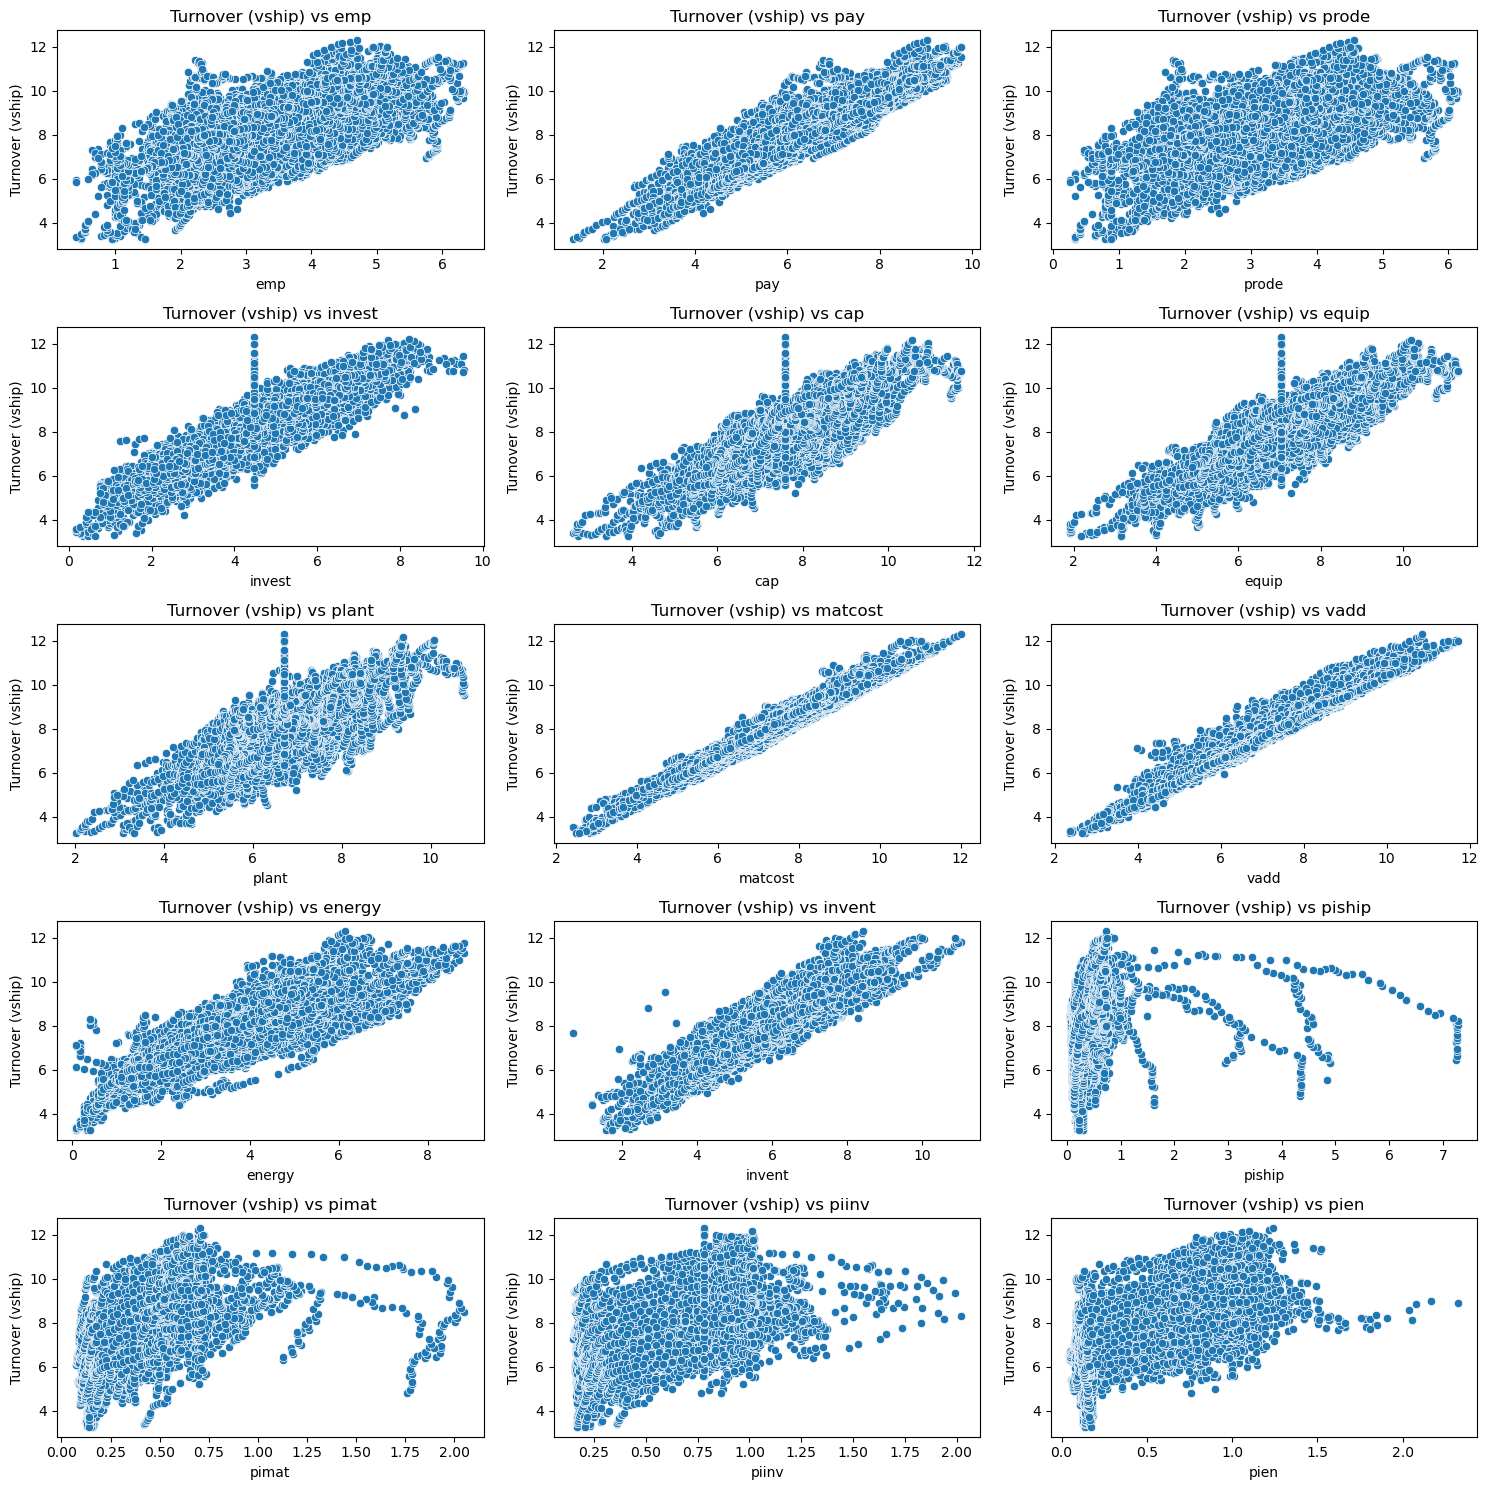

In [16]:
# Define expanded features for scatter plots
relevant_features = ["emp", "pay", "prode", "invest", "cap", "equip", "plant", "matcost", "vadd", "energy", "invent", "piship", "pimat", "piinv", "pien"]

# Set up scatter plot grid
plt.figure(figsize=(15, 15))
for i, feature in enumerate(relevant_features, 1):
    plt.subplot(5, 3, i)  # 5 rows, 3 columns of subplots
    sns.scatterplot(x=df_transformed[feature], y=df_transformed["vship"])
    plt.title(f"Turnover (vship) vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Turnover (vship)")

plt.tight_layout()
plt.show()


In [17]:
df.Subcategory.value_counts()


Food Manufacturing                                           2623
Machinery Manufacturing                                      2440
Fabricated Metal Product Manufacturing                       2196
Chemical Manufacturing                                       1769
Transportation Equipment Manufacturing                       1647
Computer & Electronic Product Manufacturing                  1464
Electrical Equipment, Appliance & Component Manufacturing    1281
Primary Metal Manufacturing                                  1098
Nonmetallic Mineral Product Manufacturing                    1098
Miscellaneous Manufacturing                                   976
Plastics & Rubber Products Manufacturing                      976
Wood Product Manufacturing                                    854
Furniture & Related Product Manufacturing                     732
Paper Manufacturing                                           671
Beverage & Tobacco Product Manufacturing                      427
Textile Mi

In [18]:
df.head()

,naics,year,emp,pay,prode,prodh,prodw,vship,matcost,vadd,...,plant,piship,pimat,piinv,pien,dtfp5,tfp5,dtfp4,tfp4,Subcategory
0,311111,1958,18.0,81.3,12.0,25.7,49.8,1042.4,752.4,266.9,...,695.0,0.354,0.133,0.168,0.116,0.017276,0.317,0.017241,0.318,Food Manufacturing
1,311111,1959,17.9,82.5,11.8,25.5,49.4,1051.0,758.9,268.7,...,725.3,0.345,0.131,0.169,0.115,0.002000,0.318,0.002000,0.318,Food Manufacturing
2,311111,1960,17.7,84.8,11.7,25.4,50.0,1050.2,752.8,269.9,...,739.2,0.274,0.129,0.173,0.119,0.217000,0.394,0.216000,0.395,Food Manufacturing
3,311111,1961,17.5,87.4,11.5,25.4,51.4,1119.7,803.6,287.8,...,752.0,0.273,0.131,0.172,0.117,0.024000,0.404,0.024000,0.405,Food Manufacturing
4,311111,1962,17.6,90.2,11.5,25.2,52.1,1175.7,853.3,294.5,...,768.7,0.277,0.132,0.174,0.119,-0.007000,0.401,-0.007000,0.402,Food Manufacturing


In [19]:
# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Subcategory'])

print(df_encoded)

        naics  year   emp     pay  prode  prodh   prodw    vship  matcost  \
0      311111  1958  18.0    81.3   12.0   25.7    49.8   1042.4    752.4   
1      311111  1959  17.9    82.5   11.8   25.5    49.4   1051.0    758.9   
2      311111  1960  17.7    84.8   11.7   25.4    50.0   1050.2    752.8   
3      311111  1961  17.5    87.4   11.5   25.4    51.4   1119.7    803.6   
4      311111  1962  17.6    90.2   11.5   25.2    52.1   1175.7    853.3   
...       ...   ...   ...     ...    ...    ...     ...      ...      ...   
21650  339999  2014  58.3  2657.0   35.5   67.6  1167.7  13857.3   5213.5   
21651  339999  2015  58.5  2738.9   34.6   66.7  1190.0  13848.1   5018.4   
21652  339999  2016  57.2  2807.3   34.3   65.7  1255.5  13997.7   4981.3   
21653  339999  2017  49.1  2381.6   32.5   60.3  1259.4  11981.0   4404.1   
21654  339999  2018  53.6  2654.2   35.0   60.2  1327.6  13153.5   4750.1   

         vadd  ...  Subcategory_Machinery Manufacturing  \
0       266.9  .

In [22]:
# Ensure Data is Sorted by Time within Each NAICS Group
df_encoded = df_encoded.sort_values(by=['naics', 'year'])

# Function to perform time-based train-test split for each NAICS category
def time_series_train_test_split(df, time_col, stratify_col, test_size=0.2):
    train_list, test_list = [], []
    
    for naics, group in df.groupby(stratify_col):  # Group by NAICS
        cutoff_idx = int(len(group) * (1 - test_size))  # Calculate split index
        train_list.append(group.iloc[:cutoff_idx])  # Train: earlier data
        test_list.append(group.iloc[cutoff_idx:])   # Test: most recent data

    return pd.concat(train_list), pd.concat(test_list)

# Apply the function
train_df, test_df = time_series_train_test_split(df, time_col='Time', stratify_col='naics')

# Show split results
print("Train Data:\n", train_df)
print("\nTest Data:\n", test_df)

# Check stratification (each NAICS should be preserved)
print("\nTrain NAICS Distribution:\n", train_df['naics'].value_counts(normalize=True))
print("\nTest NAICS Distribution:\n", test_df['naics'].value_counts(normalize=True))

Train Data:
         naics  year    emp     pay  prode  prodh   prodw    vship  matcost  \
0      311111  1958   18.0    81.3   12.0   25.7    49.8   1042.4    752.4   
1      311111  1959   17.9    82.5   11.8   25.5    49.4   1051.0    758.9   
2      311111  1960   17.7    84.8   11.7   25.4    50.0   1050.2    752.8   
3      311111  1961   17.5    87.4   11.5   25.4    51.4   1119.7    803.6   
4      311111  1962   17.6    90.2   11.5   25.2    52.1   1175.7    853.3   
...       ...   ...    ...     ...    ...    ...     ...      ...      ...   
21637  339999  2001   66.9  2002.0   44.9   84.7   966.9   8768.6   4480.7   
21638  339999  2002  103.5  3163.1   71.6  130.7  1629.7  13242.1   5826.4   
21639  339999  2003  100.2  3280.0   68.6  130.4  1639.5  13803.4   6018.0   
21640  339999  2004   96.9  3313.2   65.3  130.2  1592.0  14875.7   6233.6   
21641  339999  2005   92.8  3406.3   62.3  125.3  1685.3  16008.0   6745.2   

         vadd  ...  plant  piship  pimat  piinv   